In [141]:
import tensorflow as tf
import tensorboard as tb

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sklearn as sklearn
from sklearn.model_selection import train_test_split
import keras.preprocessing
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

import unicodedata
import os
import re
import numpy as np
import io
import time

In [142]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True
)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [143]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    w = re.sub(r"([?,!.¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = re.sub(r"[^a-zA-Z.!¡,?¿]+", " ", w)

    w = w.rstrip().strip()

    w = '<start> ' + w + ' <end>'
    
    return w

In [144]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [145]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]

    return zip(*word_pairs)

In [146]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [147]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [148]:
def load_dataset(path, num_examples=None):
    targ_lang, inp_lang, = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [149]:
num_examples = 60000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [150]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor), len(input_tensor_train), len(input_tensor_val), len(target_tensor), len(target_tensor_train), len(target_tensor_val))

60000 48000 12000 60000 48000 12000


In [151]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print("%d ----> %s" % (t, lang.index_word[t]))

In [152]:
print("Input Language: Index to Word Mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Output Language: Index to Word Mapping")
convert(targ_lang, target_tensor_train[0])

Input Language: Index to Word Mapping
1 ----> <start>
7 ----> el
2178 ----> obtuvo
14 ----> un
4080 ----> prestamo
107 ----> del
595 ----> banco
3 ----> .
2 ----> <end>

Output Language: Index to Word Mapping
1 ----> <start>
15 ----> he
82 ----> got
8 ----> a
2320 ----> loan
111 ----> from
11 ----> the
645 ----> bank
3 ----> .
2 ----> <end>


In [153]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [154]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [155]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 20]), TensorShape([64, 13]))

In [156]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [157]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Sample Input

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 20, 1024)
Encoder hidden state shape: (batch size, units) (64, 1024)


In [158]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # Query hidden state shape == (batch size, hidden size)
        # Query with time axis shape(?) == (batch size, 1, hidden size)
        # Values shape == (batch size, max_len, hidden size)
        # We are doing this to broadcast the scores along the time axis due to the sequential nature of the input/output
        query_with_time_axis = tf.expand_dims(query, 1)

        # Score shape == (batch size, max_length, 1)
        # We get 1 at the end because we're applying the score to V itself
        # The shape of the tensor before applying self.V is (batch size, max length, units)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # The shape of the attention weights == (batch size, max length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # The context vector's shape after the sum == (batch size, hidden size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [159]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print('Attention result shape: (batch size, units) {}'.format(attention_result.shape))
print('Attention weights shape: (batch size, sequence length, 1) {}'.format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch size, sequence length, 1) (64, 20, 1)


In [160]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # Used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc output shape == (batch size, max length, hidden size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # Shape of x after embedding == (batch size, 1, embedding dim)
        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

In [161]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print('Decoder output shape: (batch size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch size, vocab size) (64, 7669)


In [162]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [163]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [164]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing, feeding the target as the next input

        for t in range(1, targ.shape[1]):
            # Passing encoder output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # Using teacher forcing

            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [165]:
EPOCHS = 15

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {}, Batch {}, Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

    # Saving the checkpoint every 2 epochs

    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {}, Loss {:.4f}'.format(epoch+1, total_loss/steps_per_epoch))

    print('Time taken for 1 Epoch: {} sec\n'.format(time.time() - start))

Epoch 1, Batch 0, Loss 4.6121
Epoch 1, Batch 100, Loss 2.3281
Epoch 1, Batch 200, Loss 2.1331
Epoch 1, Batch 300, Loss 1.7610
Epoch 1, Batch 400, Loss 1.7607
Epoch 1, Batch 500, Loss 1.5748
Epoch 1, Batch 600, Loss 1.6012
Epoch 1, Batch 700, Loss 1.4444
Epoch 1, Loss 1.8399
Time taken for 1 Epoch: 163.18513870239258 sec

Epoch 2, Batch 0, Loss 1.2452
Epoch 2, Batch 100, Loss 1.1707
Epoch 2, Batch 200, Loss 1.0491
Epoch 2, Batch 300, Loss 1.2156
Epoch 2, Batch 400, Loss 1.0584
Epoch 2, Batch 500, Loss 0.9824
Epoch 2, Batch 600, Loss 0.9794
Epoch 2, Batch 700, Loss 0.7698
Epoch 2, Loss 1.0379
Time taken for 1 Epoch: 132.86286664009094 sec

Epoch 3, Batch 0, Loss 0.7703
Epoch 3, Batch 100, Loss 0.6667
Epoch 3, Batch 200, Loss 0.6112
Epoch 3, Batch 300, Loss 0.6017
Epoch 3, Batch 400, Loss 0.6337
Epoch 3, Batch 500, Loss 0.7750
Epoch 3, Batch 600, Loss 0.5597
Epoch 3, Batch 700, Loss 0.6366
Epoch 3, Loss 0.6549
Time taken for 1 Epoch: 136.33394598960876 sec

Epoch 4, Batch 0, Loss 0.4781
E

In [171]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    # inputs = tf.keras.preprocessing.sequence.pad_sequence([inputs], maxlen=max_length_inp, padding='post')

    inputs = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post'))

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # Storing the Attention Weights so we can plot them later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # The predicted ID is fed back into the model

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [176]:
# The function for plotting the attention weights:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [177]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [178]:
# Restoring the latest checkkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 
<ipython-input-176-de36e6857987>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-176-de36e6857987>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


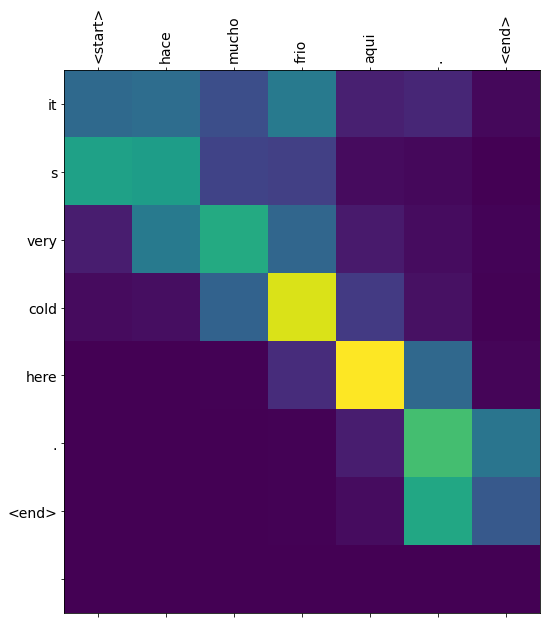

In [179]:
translate('hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 
<ipython-input-176-de36e6857987>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-176-de36e6857987>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


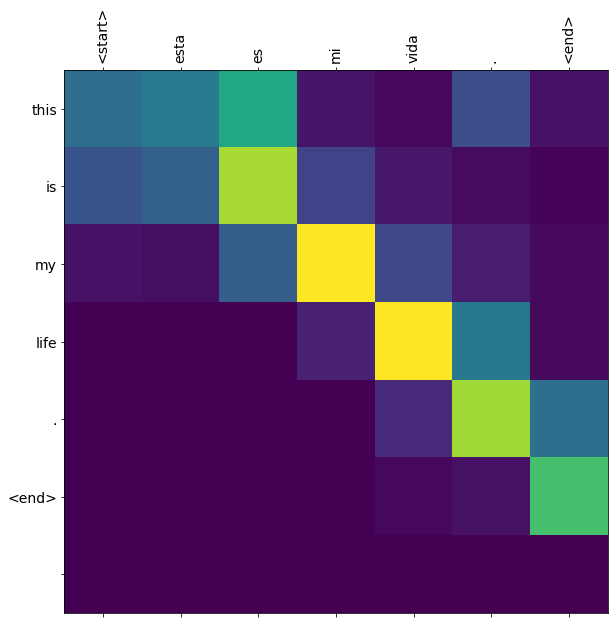

In [180]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 
<ipython-input-176-de36e6857987>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-176-de36e6857987>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


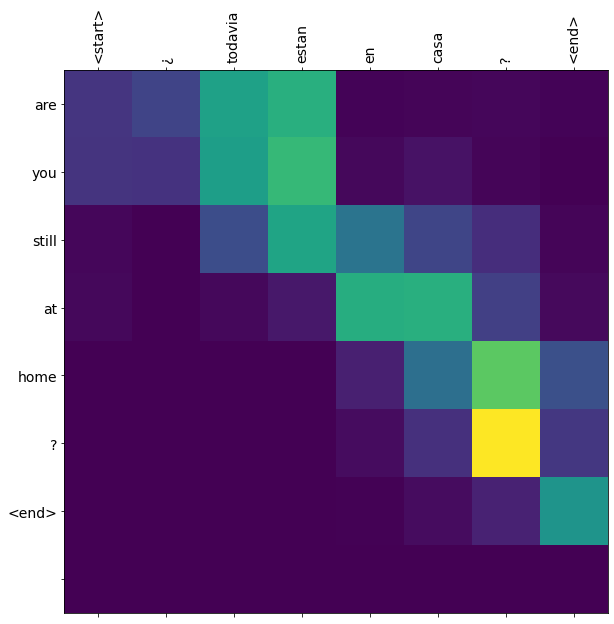

In [181]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo <end>
Predicted translation: try to figure it out . <end> 
<ipython-input-176-de36e6857987>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-176-de36e6857987>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


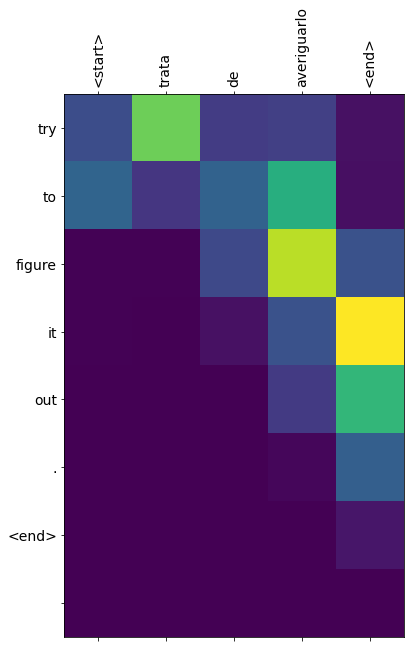

In [182]:
translate(u'trata de averiguarlo')